In [2]:
import pandas as pd

df = pd.read_csv("Merged_Microplastic_Data.csv")

null_counts = df.isnull().sum()
print(null_counts)

Unnamed: 0                                0
DOI                                       0
Sample_ID                                 0
Location                                149
Countries                               149
Source                                    0
Concentration                             6
Concentration_Units                       6
Approximate_Latitude                    155
Approximate_Longitude                   155
Sample_device_and_deployment_methods     21
Digestion                                21
Filtration                               21
Filter_Size                              21
Microplastic_Identification_Method       21
Spectral_Analysis                        21
Controls                                 21
dtype: int64


In [3]:
df

,Unnamed: 0,DOI,Sample_ID,Location,Countries,Source,Concentration,Concentration_Units,Approximate_Latitude,Approximate_Longitude,Sample_device_and_deployment_methods,Digestion,Filtration,Filter_Size,Microplastic_Identification_Method,Spectral_Analysis,Controls
0,0,10.1016/j.watres.2017.11.011,1|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,14,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
1,1,10.1016/j.watres.2017.11.011,2|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,118,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
2,2,10.1016/j.watres.2017.11.011,3|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,50,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
3,3,10.1016/j.watres.2017.11.011,4|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,11,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
4,4,10.1039/c6ay01184e,1|10.1039/c6ay01184e,Germany,Germany,bottled water,19-Oct,particles/0.33 L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,Cellulose nitrate,0.45 um,Raman scattering spectroscopy,Raman,Already analyzes sample filtered a second time...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,10.1016/j.scitotenv.2021.148001,Spr|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,390,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized
603,603,10.1016/j.scitotenv.2021.148001,Sum|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,360,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized
604,604,10.1016/j.scitotenv.2021.148001,Aut|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,750,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized
605,605,10.1016/j.scitotenv.2021.148001,Win|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,540,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized


In [4]:
df = df[~df['Location'].isnull()]

df = df.dropna(subset=['Approximate_Latitude', 'Approximate_Longitude'])
df = df.fillna('Unknown')

df

,Unnamed: 0,DOI,Sample_ID,Location,Countries,Source,Concentration,Concentration_Units,Approximate_Latitude,Approximate_Longitude,Sample_device_and_deployment_methods,Digestion,Filtration,Filter_Size,Microplastic_Identification_Method,Spectral_Analysis,Controls
0,0,10.1016/j.watres.2017.11.011,1|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,14,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
1,1,10.1016/j.watres.2017.11.011,2|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,118,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
2,2,10.1016/j.watres.2017.11.011,3|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,50,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
3,3,10.1016/j.watres.2017.11.011,4|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,11,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
4,4,10.1039/c6ay01184e,1|10.1039/c6ay01184e,Germany,Germany,bottled water,19-Oct,particles/0.33 L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,Cellulose nitrate,0.45 um,Raman scattering spectroscopy,Raman,Already analyzes sample filtered a second time...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,10.1016/j.scitotenv.2021.148001,Spr|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,390,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized
603,603,10.1016/j.scitotenv.2021.148001,Sum|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,360,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized
604,604,10.1016/j.scitotenv.2021.148001,Aut|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,750,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized
605,605,10.1016/j.scitotenv.2021.148001,Win|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,540,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized


In [5]:
df['Location'].unique()

array(['Germany', 'Jakarta, Indonesia', 'Bali, Indonesia',
       'Medan, Indonesia', 'Chennai, India', 'Mumbai, India',
       'New Delhi, India', 'Nairobi, Kenya', 'Mexico City, Mexico',
       'Tijuana, Mexico', 'Reynosa, Mexico', 'Fredonia, NY, USA',
       'Sao Paulo, Brazil', 'Aparecida de Goiania, Brazil',
       'Rio de Janerio, Brazil', 'Beirut, Lebanon', 'Bangkok, Thailand',
       'Jinan, China', 'Beijing, China', 'Qingdao, China', 'Havana, Cuba',
       'Quito, Ecuador', 'Paris, France',
       'Berlin, Germany; Tubingen, Germany', 'Ner Delhi, India',
       'Depok City, Indonesia; Desa Puspanegara, Indonesia; Jakarta, Indonesia; Jatirahayu, Indonesia; Kedaung, Indonesia; Menteng, Indonesia; North Paninggilan, Indonesia; Pasireurih, Indonesia; South Tangerang City, Indonesia; Sukatani, Indonesia; Teluknaga, Indonesia; Warnasari, Indonesia',
       'Dublin, Ireland', 'Pavia, Italy',
       'Beirut, Lebanon; Burj el Brajneh, Lebanon; Choueifat, Lebanon; Ghobayreh, Lebanon; Kh

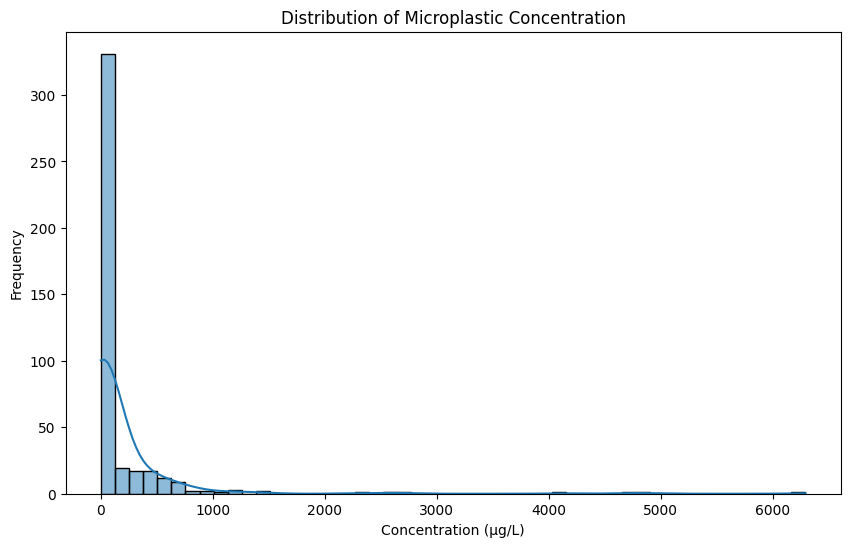

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure 'Concentration' is numeric
df['Concentration'] = pd.to_numeric(df['Concentration'], errors='coerce')

# Drop missing values
df = df.dropna(subset=['Concentration'])

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(df['Concentration'], kde=True, bins=50)
plt.title("Distribution of Microplastic Concentration")
plt.xlabel("Concentration (µg/L)")
plt.ylabel("Frequency")
plt.show()


### Microplastic Concentration by Filtration Method

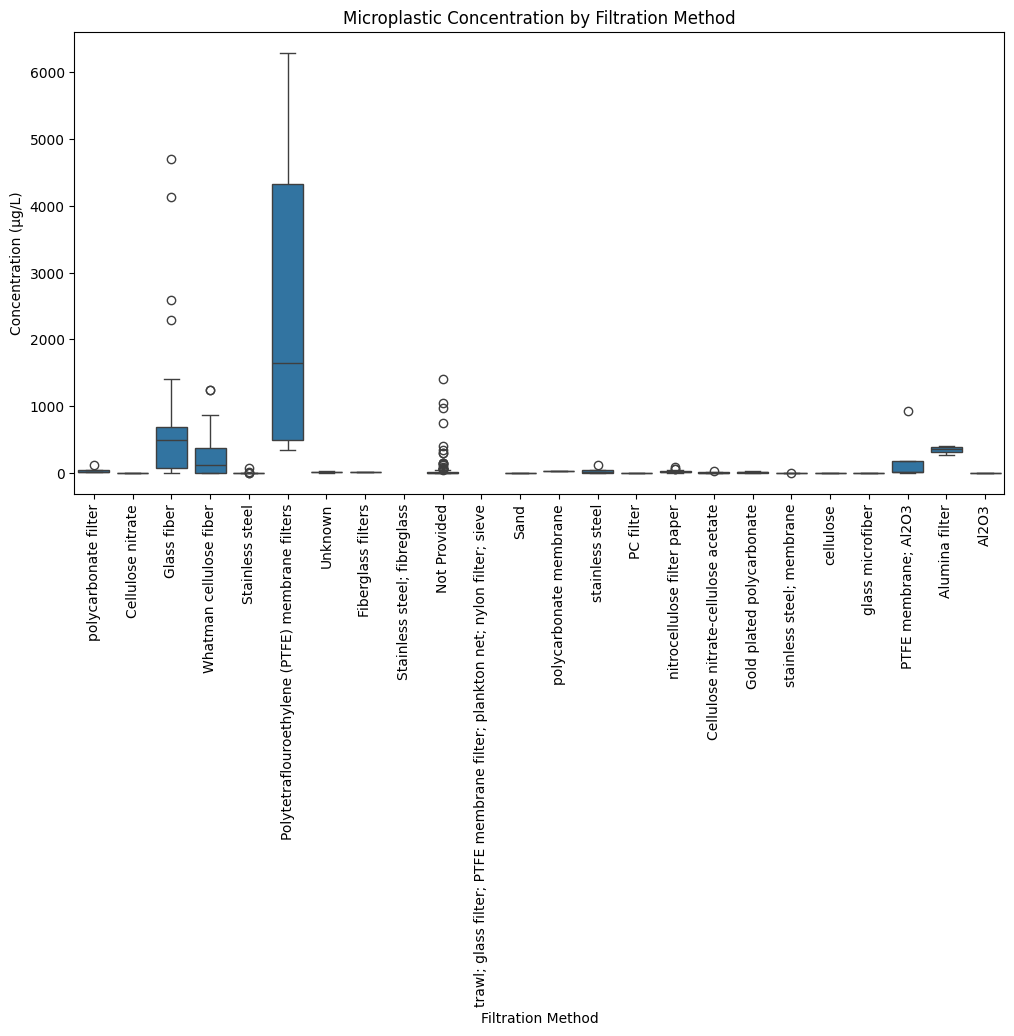

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("Merged_Microplastic_Data.csv")

# Handling missing values
df = df[~df['Location'].isnull()]  # Remove rows where 'Location' is null
df = df.dropna(subset=['Approximate_Latitude', 'Approximate_Longitude'])  # Remove rows with missing coordinates
df = df.fillna('Unknown')  # Fill remaining NaNs with 'Unknown'

# Convert 'Concentration' to numeric while avoiding SettingWithCopyWarning
df = df.copy()  # Ensure we're modifying the DataFrame safely
df['Concentration'] = pd.to_numeric(df['Concentration'], errors='coerce')  # Convert to numeric

# Visualization: Microplastic Concentration by Filtration Method
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Filtration', y='Concentration')
plt.title("Microplastic Concentration by Filtration Method")
plt.xlabel("Filtration Method")
plt.ylabel("Concentration (µg/L)")
plt.xticks(rotation=90)
plt.show()



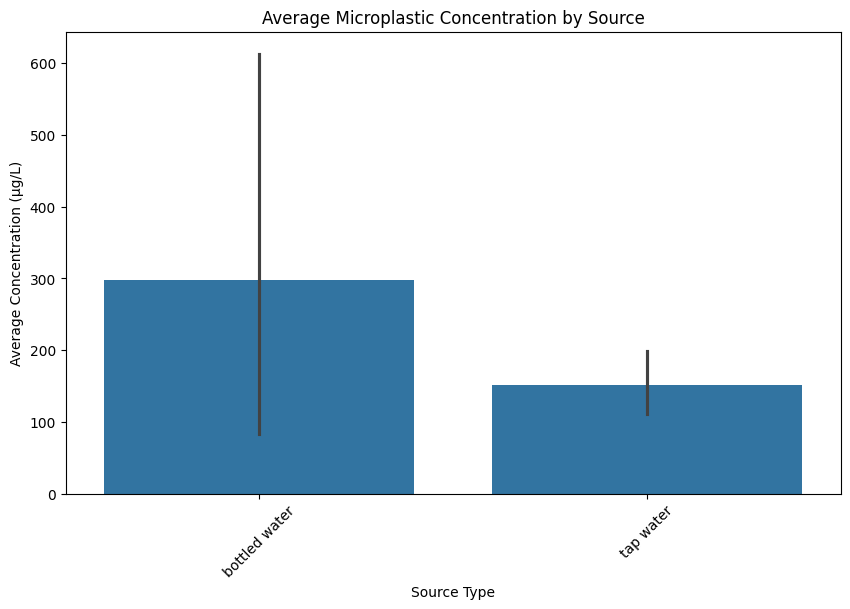

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Handling missing values
df = df[~df['Location'].isnull()]
df = df.dropna(subset=['Approximate_Latitude', 'Approximate_Longitude'])
df = df.fillna('Unknown')

# Convert 'Concentration' to numeric safely
df = df.copy()
df['Concentration'] = pd.to_numeric(df['Concentration'], errors='coerce')

# Visualization: Average Microplastic Concentration by Source
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Source', y='Concentration', estimator=np.mean)
plt.title("Average Microplastic Concentration by Source")
plt.xlabel("Source Type")
plt.ylabel("Average Concentration (µg/L)")
plt.xticks(rotation=45)
plt.show()



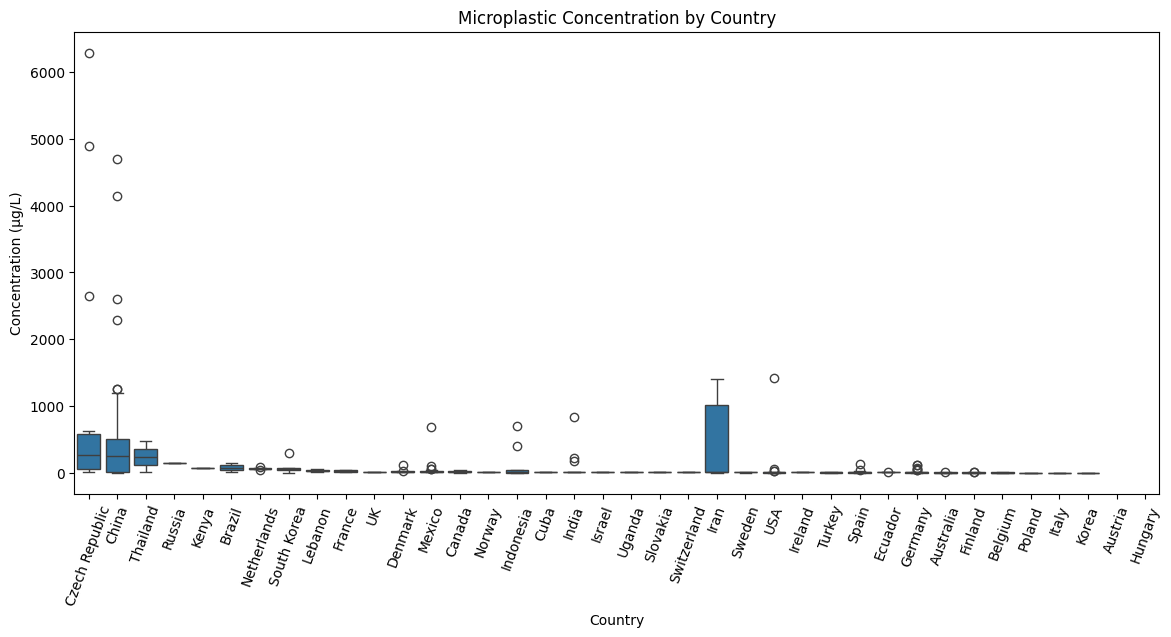

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sort countries by median concentration for better visualization
country_order = df.groupby('Countries')['Concentration'].median().sort_values(ascending=False).index

plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='Countries', y='Concentration', order=country_order)
plt.title("Microplastic Concentration by Country")
plt.xlabel("Country")
plt.ylabel("Concentration (µg/L)")
plt.xticks(rotation=70)

# Optionally set y-axis to log scale if values are highly skewed
# plt.yscale('log')

plt.show()


In [10]:
from scipy import stats
filtration_groups = df.groupby('Filtration')['Concentration'].apply(list)
digestion_groups = df.groupby('Digestion')['Concentration'].apply(list)

# Perform ANOVA for Filtration Methods
f_stat, p_val = stats.f_oneway(*filtration_groups)
print(f"ANOVA result for Filtration methods: F-statistic = {f_stat}, p-value = {p_val}")

# Perform ANOVA for Digestion Methods
f_stat, p_val = stats.f_oneway(*digestion_groups)
print(f"ANOVA result for Digestion methods: F-statistic = {f_stat}, p-value = {p_val}")


ANOVA result for Filtration methods: F-statistic = nan, p-value = nan
ANOVA result for Digestion methods: F-statistic = nan, p-value = nan


In [11]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ANOVA model for Filtration methods
model = ols('Concentration ~ Filtration', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Tukey's HSD test
tukey = pairwise_tukeyhsd(df['Concentration'], df['Filtration'], alpha=0.05)
print(tukey)


C:\Users\arman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 21
  warnings.warn('covariance of constraints does not have full '


                  sum_sq     df          F        PR(>F)
Filtration  5.650212e+07   23.0  11.515078  7.071728e-30
Residual    8.533555e+07  400.0        NaN           NaN
                                                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                                                       
                     group1                                                        group2                                     meandiff  p-adj lower upper reject
----------------------------------------------------------------------------------------------------------------------------------------------------------------
                                          Al2O3                                                               Alumina filter     347.55   nan   nan   nan  False
                                          Al2O3                                                            Cellulose nitrate        nan   nan   nan   nan  False
                        

C:\Users\arman\AppData\Local\Temp\ipykernel_22912\4286999351.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=country_stats, x='Countries', y='max_concentration', palette='Reds_r')


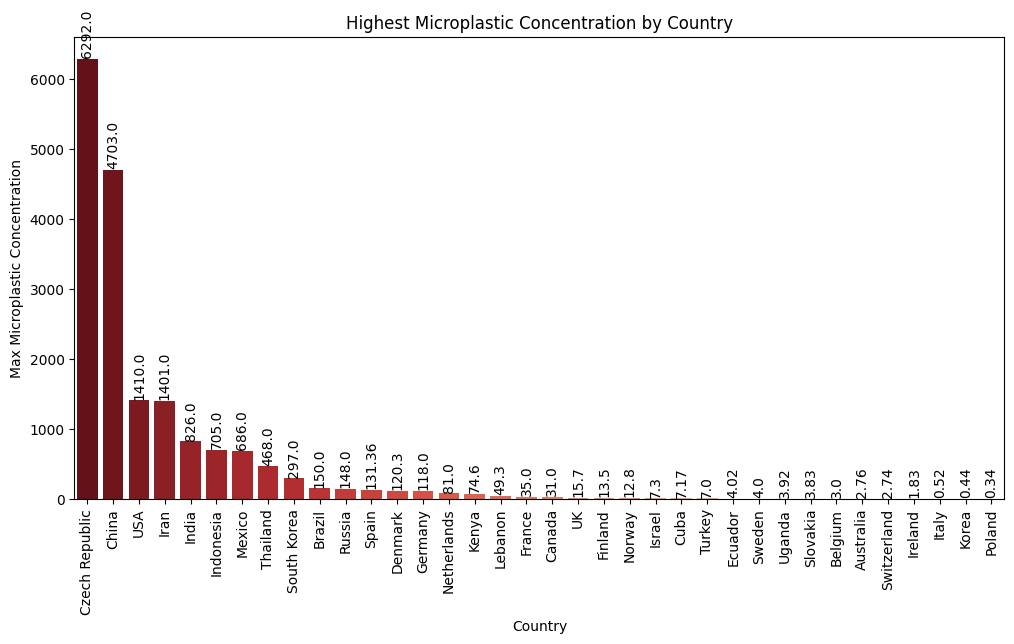

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df
df_clean = df.dropna(subset=['Concentration', 'Countries'])  # Remove missing values

# Aggregate Data
country_stats = df_clean.groupby('Countries').agg(
    max_concentration=('Concentration', 'max'),
    mean_concentration=('Concentration', 'mean'),
    sample_count=('Concentration', 'count')
).reset_index()

# Sort by highest max concentration
country_stats = country_stats.sort_values(by='max_concentration', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=country_stats, x='Countries', y='max_concentration', palette='Reds_r')

# Add vertical data labels
for index, row in enumerate(country_stats.itertuples()):
    ax.text(index, row.max_concentration + 10, str(round(row.max_concentration, 2)), 
            ha='center', va='bottom', fontsize=10, rotation=90)  # Rotate text vertically

plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Max Microplastic Concentration')
plt.title('Highest Microplastic Concentration by Country')

plt.show()


In [13]:
# Count the number of entries per country
country_counts = df['Countries'].value_counts()

# Display the result
print(country_counts)


Countries
China             139
Germany            49
Mexico             45
USA                34
Denmark            20
India              17
Czech Republic     15
Ecuador            13
Spain              10
Finland            10
Indonesia           9
Netherlands         8
Australia           7
Korea               7
Iran                7
Sweden              7
France              6
Canada              6
Turkey              5
South Korea         5
Brazil              4
Italy               4
Belgium             4
Norway              3
Thailand            2
UK                  2
Israel              2
Lebanon             2
Kenya               1
Cuba                1
Switzerland         1
Slovakia            1
Uganda              1
Ireland             1
Hungary             1
Austria             1
Russia              1
Poland              1
Name: count, dtype: int64


In [14]:
usa = df[df['Countries'] == "USA"]

# display max rows and columns
pd.set_option('display.max_columns', None)

#pd.set_option('display.max_rows', None)

usa

,Unnamed: 0,DOI,Sample_ID,Location,Countries,Source,Concentration,Concentration_Units,Approximate_Latitude,Approximate_Longitude,Sample_device_and_deployment_methods,Digestion,Filtration,Filter_Size,Microplastic_Identification_Method,Spectral_Analysis,Controls
20,20,10.3389/fchem.2018.00407,PRD 05 24 17 11:29|10.3389/fchem.2018.00407,"Fredonia, NY, USA",USA,bottled water,58.200000,particles/L,39.78373,-100.445882,Pre packaged bevarage cartons,Not Provided,Glass fiber,1.5 um,Nile red; visual,FTIR,DI procedural blanks
21,21,10.3389/fchem.2018.00407,07.142018 2|10.3389/fchem.2018.00407,"Fredonia, NY, USA",USA,bottled water,1410.000000,particles/L,39.78373,-100.445882,Pre packaged bevarage cartons,Not Provided,Glass fiber,1.5 um,Nile red; visual,FTIR,DI procedural blanks
46,46,10.1371/journal.pone.0194970,Tap Water_USA|10.1371/journal.pone.0194970,"Alpena, USA; Buffalo, USA; Chicago, USA; Clayt...",USA,tap water,9.240000,particles/L,39.78373,-100.445882,"Tap water, beer",Not Provided,Whatman cellulose fiber,2.5 um,Rose Bengal stain; visual,FTIR,DI procedural blanks
47,47,10.1371/journal.pone.0194970,Bottled Water|10.1371/journal.pone.0194970,USA,USA,bottled water,3.570000,particles/L,39.78373,-100.445882,"Tap water, beer",Not Provided,Whatman cellulose fiber,2.5 um,Rose Bengal stain; visual,FTIR,DI procedural blanks
48,48,10.1371/journal.pone.0194970,Lake Superior 1|10.1371/journal.pone.0194970,Lake Superior,USA,bottled water,0.670000,particles/L,39.78373,-100.445882,"Tap water, beer",Not Provided,Whatman cellulose fiber,2.5 um,Rose Bengal stain; visual,FTIR,DI procedural blanks
49,49,10.1371/journal.pone.0194970,Lake Superior 2|10.1371/journal.pone.0194970,Lake Superior,USA,bottled water,4.330000,particles/L,39.78373,-100.445882,"Tap water, beer",Not Provided,Whatman cellulose fiber,2.5 um,Rose Bengal stain; visual,FTIR,DI procedural blanks
50,50,10.1371/journal.pone.0194970,Lake Superior 3|10.1371/journal.pone.0194970,Lake Superior,USA,bottled water,3.330000,particles/L,39.78373,-100.445882,"Tap water, beer",Not Provided,Whatman cellulose fiber,2.5 um,Rose Bengal stain; visual,FTIR,DI procedural blanks
51,51,10.1371/journal.pone.0194970,Lake Michigan 1|10.1371/journal.pone.0194970,Lake Michigan,USA,bottled water,1.330000,particles/L,39.78373,-100.445882,"Tap water, beer",Not Provided,Whatman cellulose fiber,2.5 um,Rose Bengal stain; visual,FTIR,DI procedural blanks
52,52,10.1371/journal.pone.0194970,Lake Michigan 2|10.1371/journal.pone.0194970,Lake Michigan,USA,bottled water,0.000000,particles/L,39.78373,-100.445882,"Tap water, beer",Not Provided,Whatman cellulose fiber,2.5 um,Rose Bengal stain; visual,FTIR,DI procedural blanks
53,53,10.1371/journal.pone.0194970,Lake Michigan 3|10.1371/journal.pone.0194970,Lake Michigan,USA,bottled water,14.300000,particles/L,39.78373,-100.445882,"Tap water, beer",Not Provided,Whatman cellulose fiber,2.5 um,Rose Bengal stain; visual,FTIR,DI procedural blanks


# This is only for Counties China', 'Germany', 'Mexico', 'USA', 'Denmark'

### Distribution of Concentration by Filtration Method


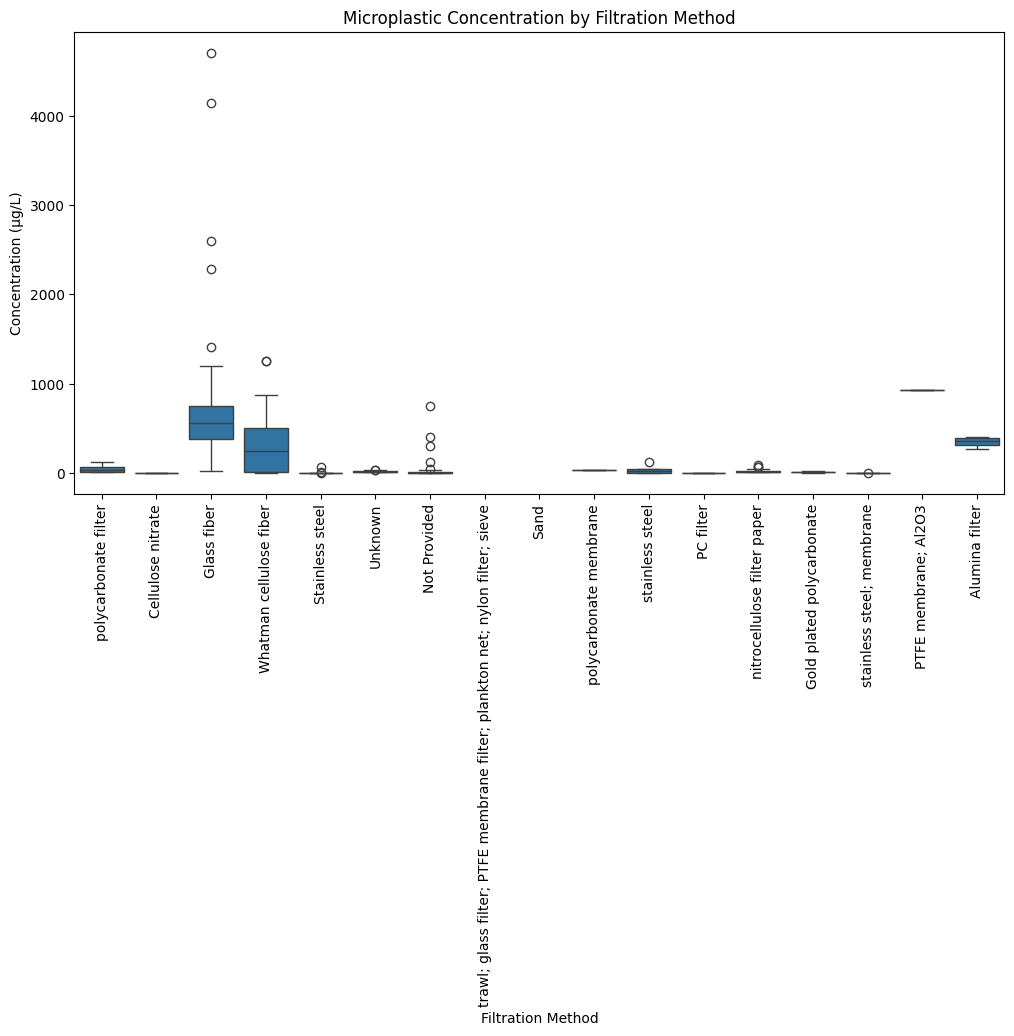

In [15]:
#
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['Countries'].isin(['China', 'Germany', 'Mexico', 'USA', 'Denmark'])], 
            x='Filtration', y='Concentration')
plt.title("Microplastic Concentration by Filtration Method")
plt.xlabel("Filtration Method")
plt.ylabel("Concentration (µg/L)")
plt.xticks(rotation=90)
plt.show()


### Average Concentration by Filtration Method

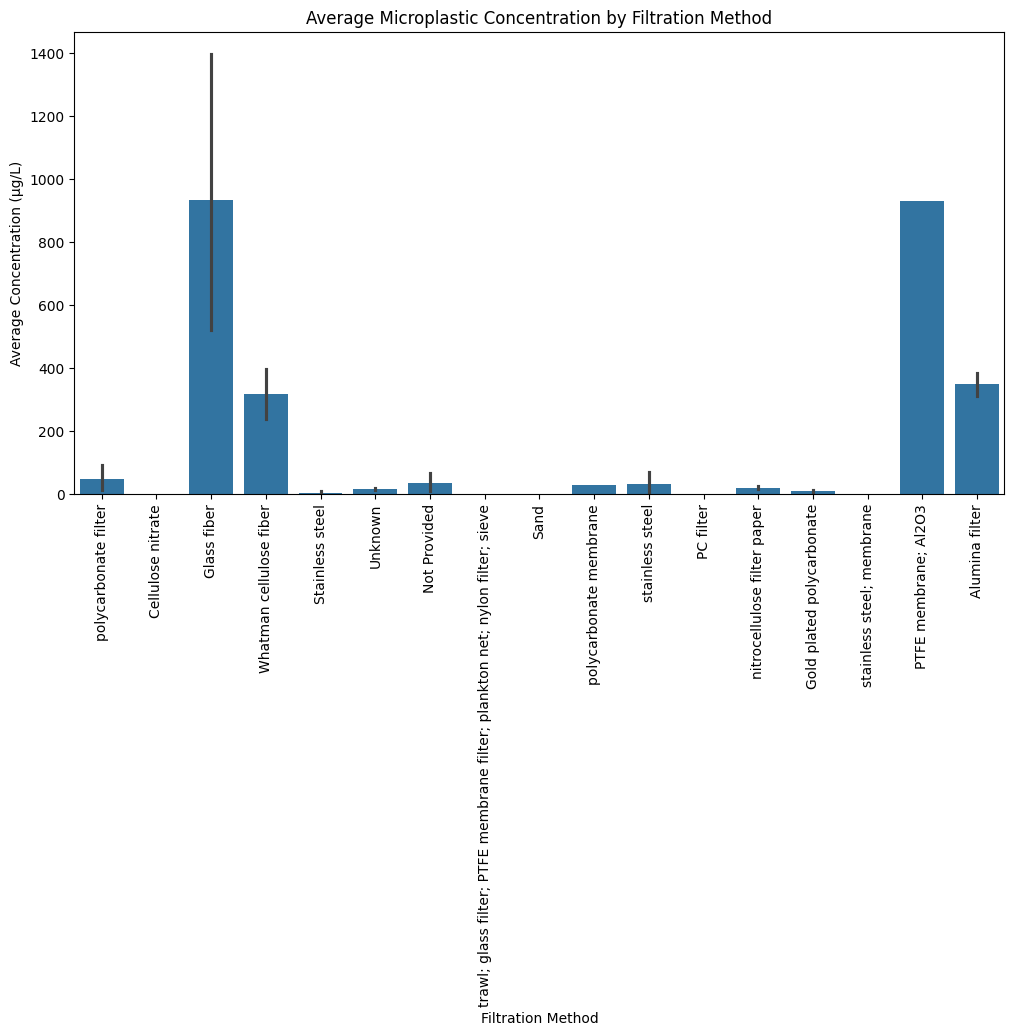

In [16]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df[df['Countries'].isin(['China', 'Germany', 'Mexico', 'USA', 'Denmark'])], 
            x='Filtration', y='Concentration', estimator='mean')
plt.title("Average Microplastic Concentration by Filtration Method")
plt.xlabel("Filtration Method")
plt.ylabel("Average Concentration (µg/L)")
plt.xticks(rotation=90)
plt.show()


### Count of Samples by Filtration Method and Country

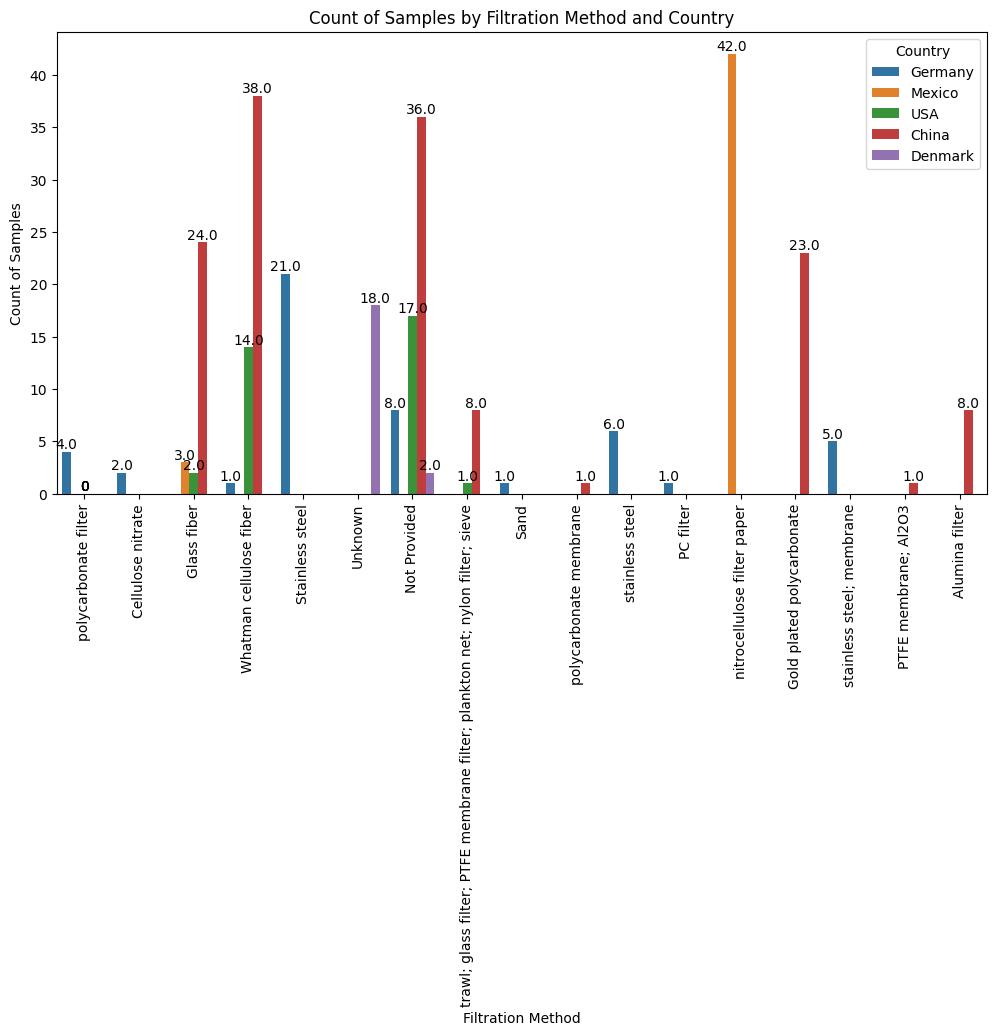

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Create the countplot for Filtration Method by Country
ax = sns.countplot(data=df[df['Countries'].isin(['China', 'Germany', 'Mexico', 'USA', 'Denmark'])], 
                   x='Filtration', hue='Countries')

# Add numbers on top of each bar with smaller font size
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',  # Display the count
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position: middle of the bar
                ha='center', va='center',  # Center the text
                fontsize=10, color='black',  # Smaller font size
                xytext=(0, 5),  # Text offset
                textcoords='offset points')

# Set plot titles and labels
plt.title("Count of Samples by Filtration Method and Country")
plt.xlabel("Filtration Method")
plt.ylabel("Count of Samples")
plt.xticks(rotation=90)
plt.legend(title='Country')
plt.show()

### Microplastic Concentration Distribution by Filtration Method and Country

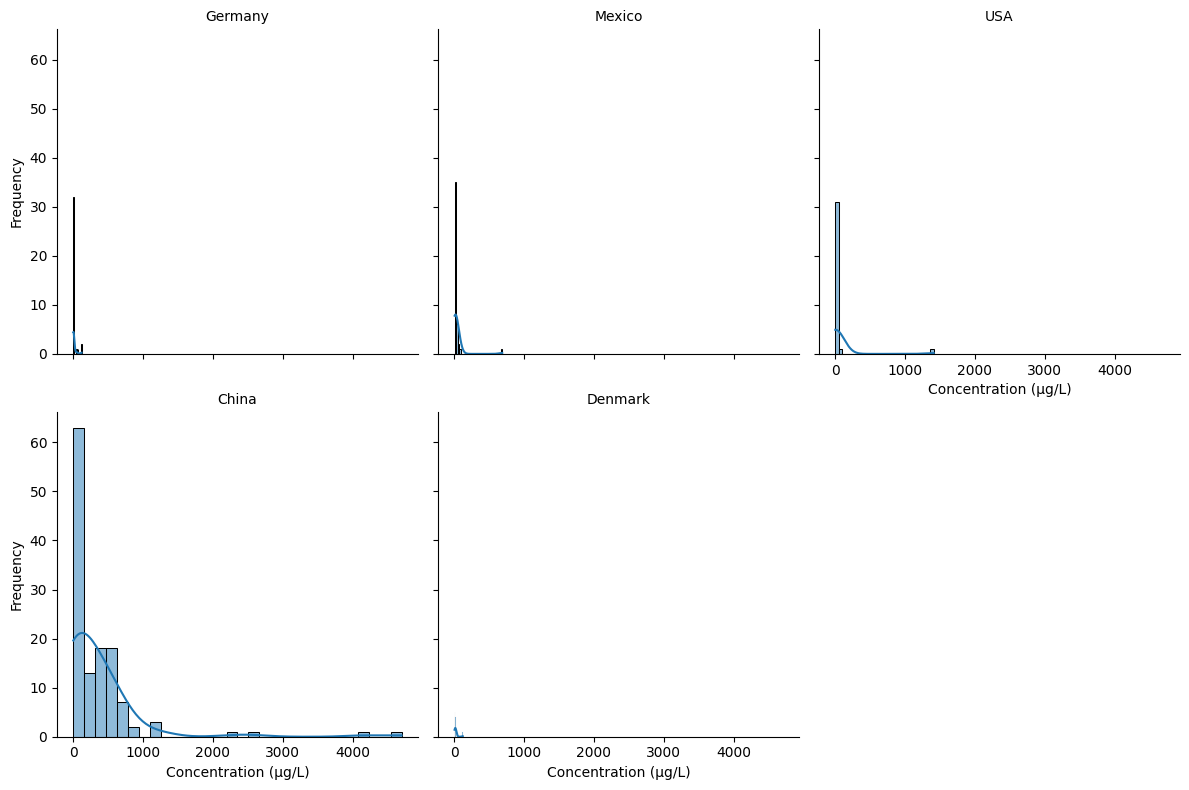

In [18]:
g = sns.FacetGrid(df[df['Countries'].isin(['China', 'Germany', 'Mexico', 'USA', 'Denmark'])], col="Countries", 
                  col_wrap=3, height=4)
g.map(sns.histplot, 'Concentration', kde=True, bins=30)
g.set_axis_labels('Concentration (µg/L)', 'Frequency')
g.set_titles("{col_name}")
plt.show()


# These only compare USA and Germany

### Count of Samples by Filtration Method for USA and Germany

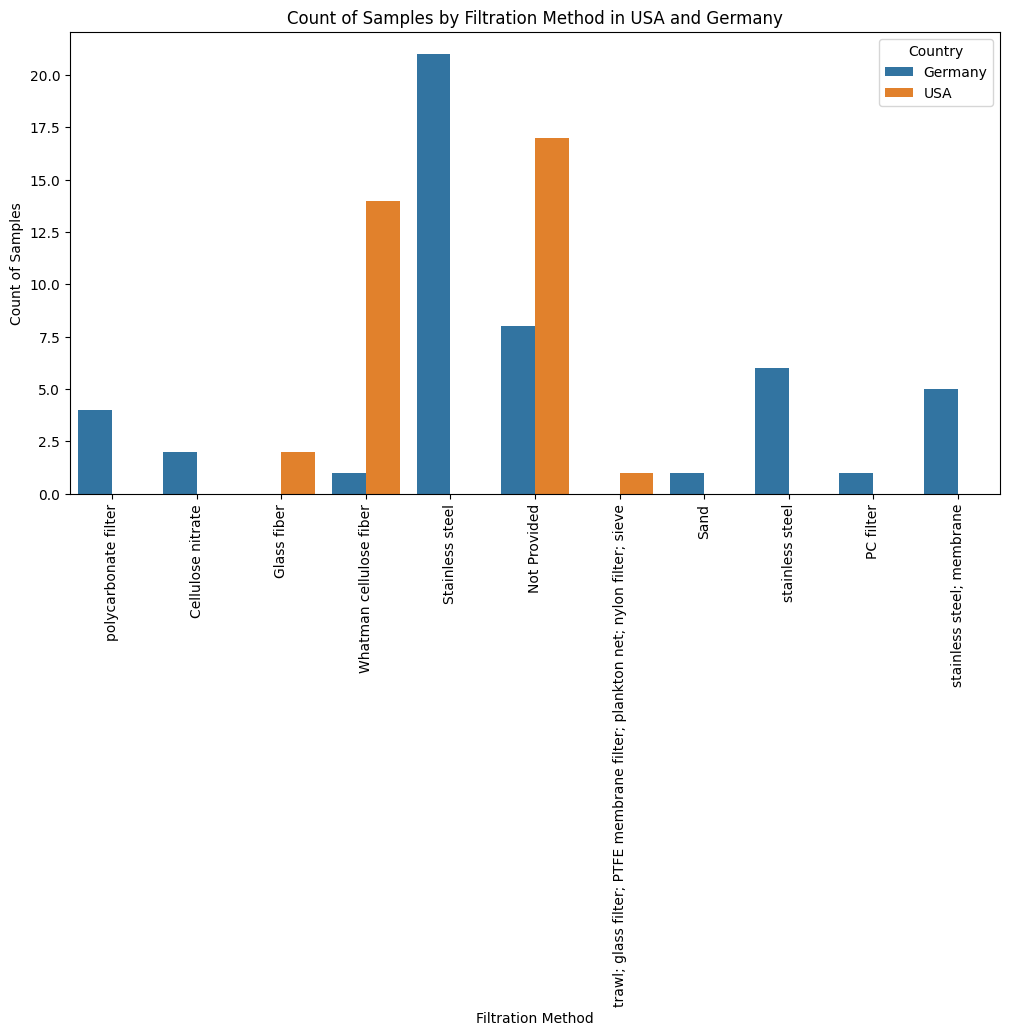

In [20]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df[df['Countries'].isin(['USA', 'Germany'])], x='Filtration', hue='Countries')
plt.title("Count of Samples by Filtration Method in USA and Germany")
plt.xlabel("Filtration Method")
plt.ylabel("Count of Samples")
plt.xticks(rotation=90)
plt.legend(title='Country')
plt.show()


### Microplastic Concentration by Filtration Method in USA and Germany

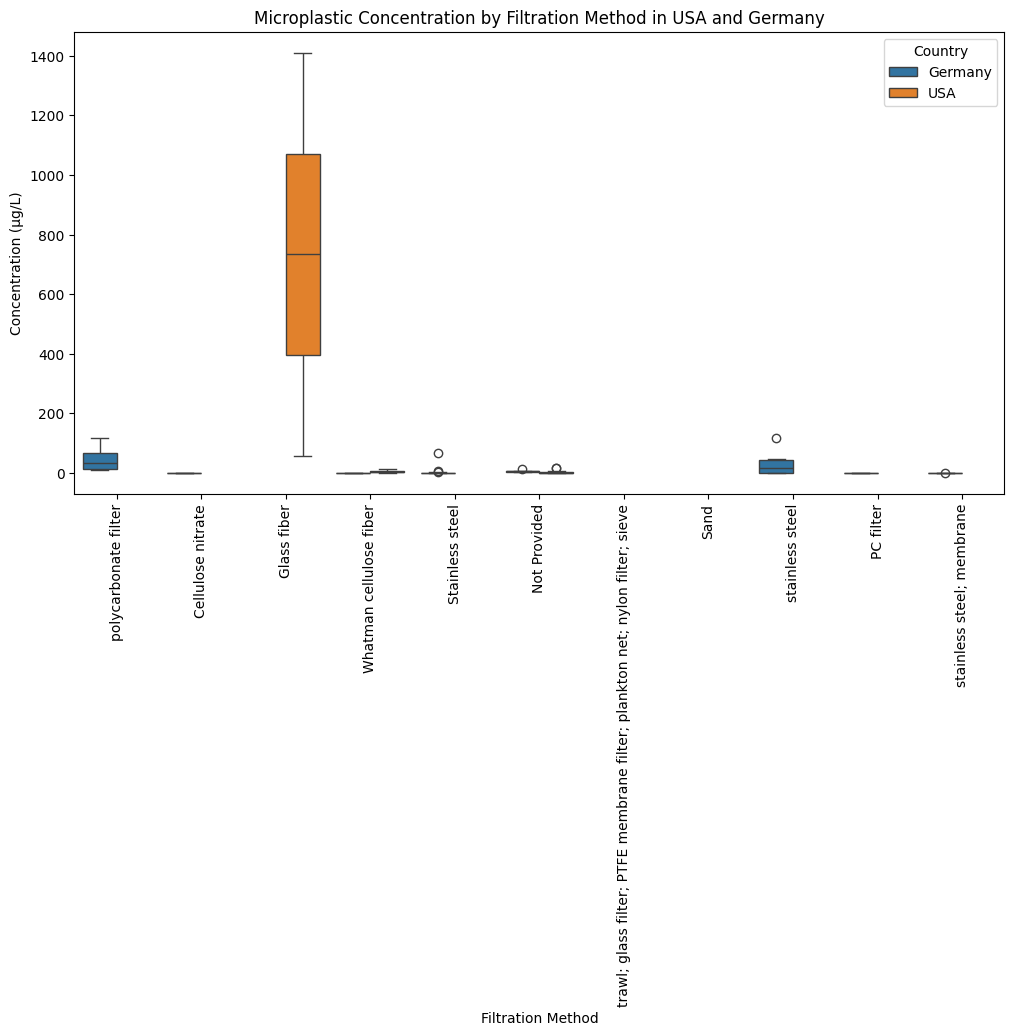

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['Countries'].isin(['USA', 'Germany'])], x='Filtration', y='Concentration', hue='Countries')
plt.title("Microplastic Concentration by Filtration Method in USA and Germany")
plt.xlabel("Filtration Method")
plt.ylabel("Concentration (µg/L)")
plt.xticks(rotation=90)
plt.legend(title='Country')
plt.show()


### Average Microplastic Concentration by Filtration Method in USA and Germany

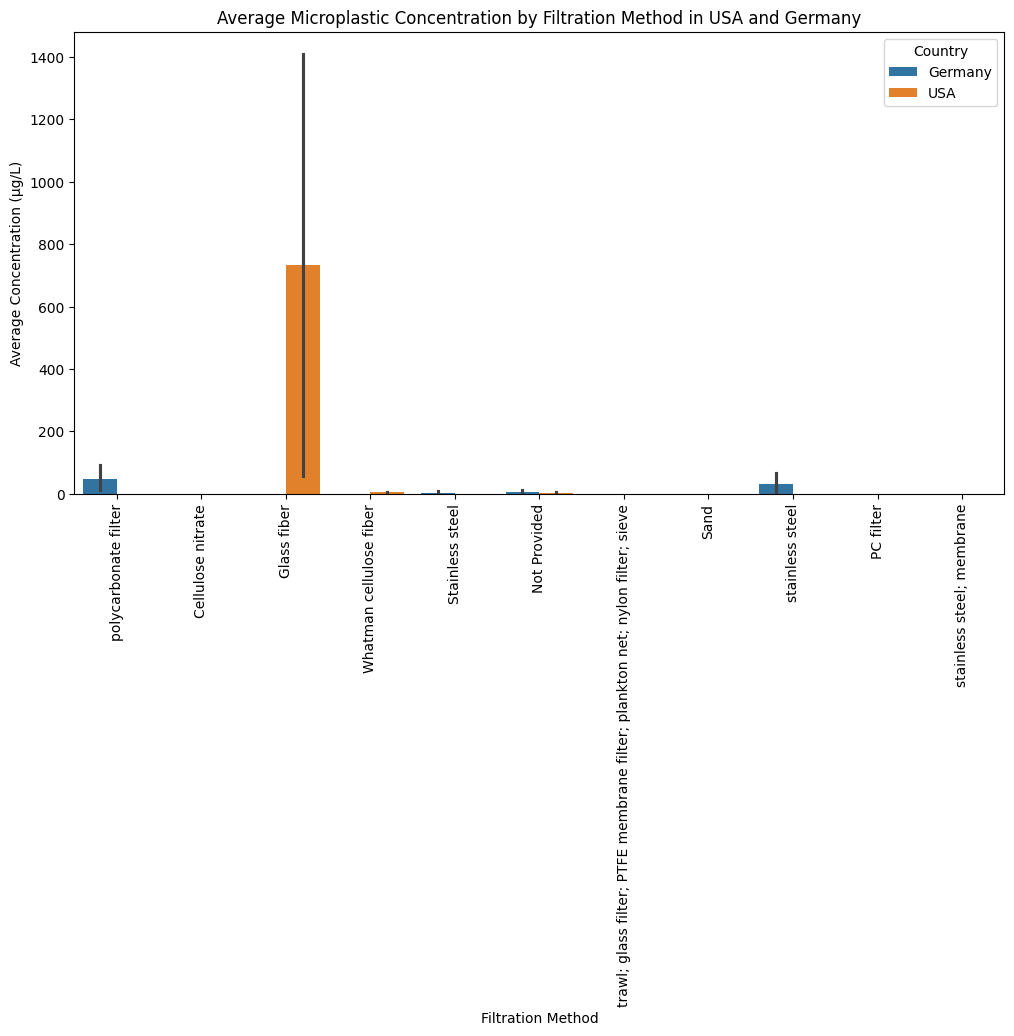

In [24]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df[df['Countries'].isin(['USA', 'Germany'])], x='Filtration', y='Concentration', hue='Countries', estimator='mean')
plt.title("Average Microplastic Concentration by Filtration Method in USA and Germany")
plt.xlabel("Filtration Method")
plt.ylabel("Average Concentration (µg/L)")
plt.xticks(rotation=90)
plt.legend(title='Country')
plt.show()


<Figure size 1200x600 with 0 Axes>

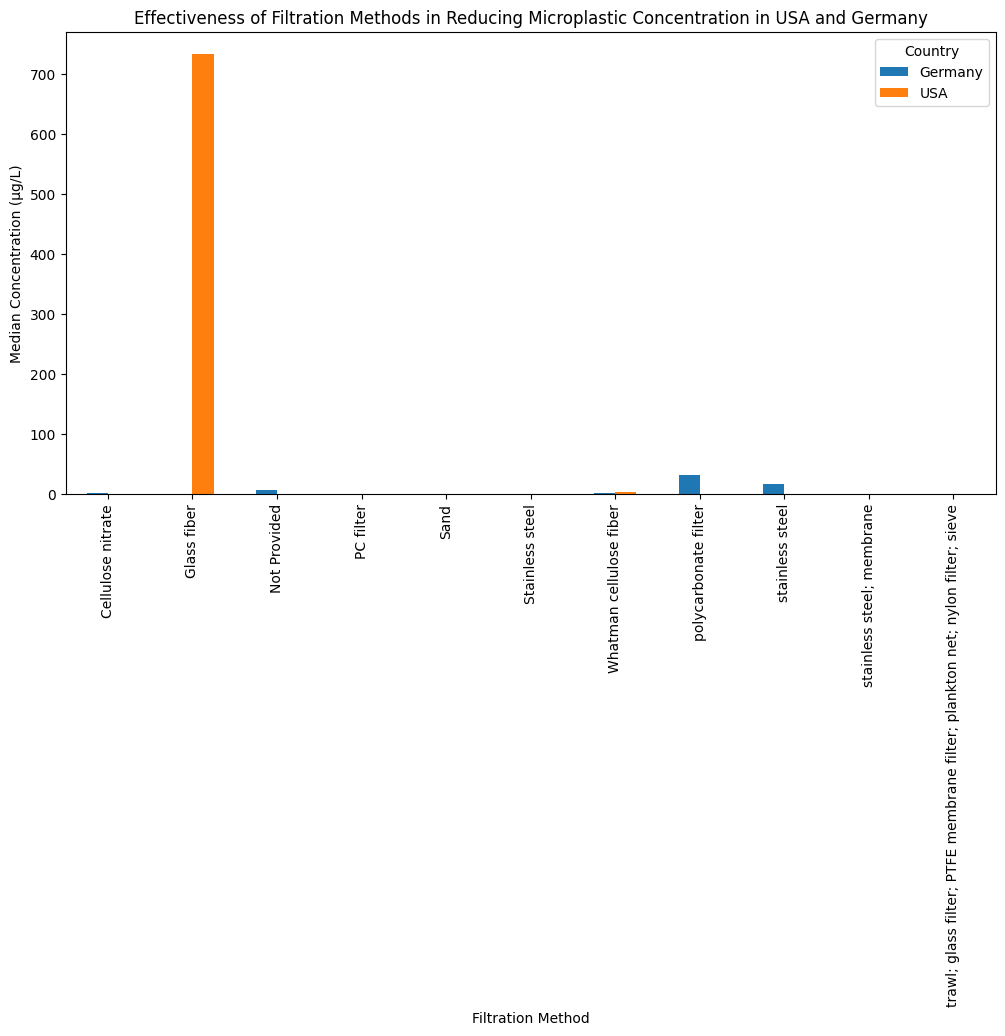

In [26]:
plt.figure(figsize=(12, 6))
medians = df[df['Countries'].isin(['USA', 'Germany'])].groupby(['Filtration', 'Countries'])['Concentration'].median().unstack()
medians.plot(kind='bar', figsize=(12, 6))
plt.title("Effectiveness of Filtration Methods in Reducing Microplastic Concentration in USA and Germany")
plt.xlabel("Filtration Method")
plt.ylabel("Median Concentration (µg/L)")
plt.xticks(rotation=90)
plt.legend(title='Country')
plt.show()
